<img style="max-width:20em; height:auto;" src="../graphics/A-Little-Book-on-Adversarial-AI-Cover.png"/>

Author: Nik Alleyne   
Author Blog: https://www.securitynik.com   
Author GitHub: github.com/securitynik   

Author Other Books: [   

            "https://www.amazon.ca/Learning-Practicing-Leveraging-Practical-Detection/dp/1731254458/",   
            
            "https://www.amazon.ca/Learning-Practicing-Mastering-Network-Forensics/dp/1775383024/"   
        ]   


This notebook ***(fgsm_foolbox.ipynb)*** is part of the series of notebooks From ***A Little Book on Adversarial AI***  A free ebook released by Nik Alleyne

### Leverage Foolbox to do FGSM

### Lab Objectives:  
- Use a framework to simplify the problem of performing FGSM attack  
- Learn how to use *foolbox*   
- Build on what we learnt earlier    
- Introduce the foolbox framework  


### Step 1:   
Get the data

In [1]:
# https://arxiv.org/pdf/2010.01950
# https://ar5iv.labs.arxiv.org/html/2010.01950
import foolbox as fb
import torch
import numpy as np

import matplotlib.pyplot as plt

In [2]:
### Version of key libraries used  
print(f'Torch version used:  {torch.__version__}')
print(f'Foolbox version used:  {fb.__version__}')

Torch version used:  2.7.1+cu128
Foolbox version used:  3.3.4


In [3]:
# Setup the device to work with
# This should ensure if there are accelerators in place, such as Apple backend or CUDA, 
# we should be able to take advantage of it.

if torch.cuda.is_available():
    print('Setting the device to cuda')
    device = 'cuda'
elif torch.backends.mps.is_available():
    print('Setting the device to Apple mps')
    device = 'mps'
else:
    print('Setting the device to CPU')
    device = torch.device('cpu')

Setting the device to cuda


In [4]:
# Load the test set
# This is from the Tiny Malware
X_y = np.load(r'../data/tiny_mal_net_X_y_test.npz', allow_pickle=False)
X = X_y['X']
y = X_y['y']

# Get the shape of the dataset
X.shape, y.shape

((1000, 256), (1000,))

In [5]:
# Convert both the feature and targets to torch tensors
# These currently have dimensions (1, 1, 256, 256) -> (batch_size, channels, height, width)
X = torch.tensor(X.reshape(-1, 1, 16, 16), dtype=torch.float32, device=device)

# Convert the labels also to torch tensors
y = torch.tensor(y, dtype=torch.long, device=device)

### Step 2:  
Load the model  

In [6]:
# Let's load the model we will target
loaded_malware_classifier = torch.jit.load(r'../data/mal_net_tiny_malware_clf.jit', map_location=device)
loaded_malware_classifier.eval()

RecursiveScriptModule(
  original_name=MalClassifier
  (conv_layers): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_name=BatchNorm2d)
    (2): RecursiveScriptModule(original_name=ReLU)
    (3): RecursiveScriptModule(original_name=Conv2d)
    (4): RecursiveScriptModule(original_name=BatchNorm2d)
    (5): RecursiveScriptModule(original_name=ReLU)
    (6): RecursiveScriptModule(original_name=Conv2d)
    (7): RecursiveScriptModule(original_name=BatchNorm2d)
    (8): RecursiveScriptModule(original_name=ReLU)
  )
  (global_avg_pool): RecursiveScriptModule(original_name=AdaptiveAvgPool2d)
  (classifier): RecursiveScriptModule(original_name=Conv2d)
)

### Step 3:   
Create the attack via *foolbox* 

In [7]:
# With that undersanding out of the way, let's now use the foolbox ai tool for performing the same attack
# https://github.com/bethgelab/foolbox
# https://foolbox.readthedocs.io/en/stable/index.html
import foolbox as fb

In [8]:
# Setup the foolbox model
fb_model = fb.PyTorchModel(model=loaded_malware_classifier, bounds=(0, 1))
fb_model

### Step 4:  
Setup the PGD attack   

In [9]:
# Setup the Foolbox attack
fb_fgsm_attack = fb.attacks.FGSM(random_start=False)
fb_fgsm_attack

LinfFastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)

In [10]:
# Generate the adversarial examples  
raw_adversarial_examples, clipped_adversarial_examples, success =  fb_fgsm_attack(fb_model, X,  y, epsilons=0.007)

In [11]:
# Get the Attack Success Rate
success.sum() / len(success)

tensor(0.2530, device='cuda:0')

### Step 5:  
Visualize the attack  

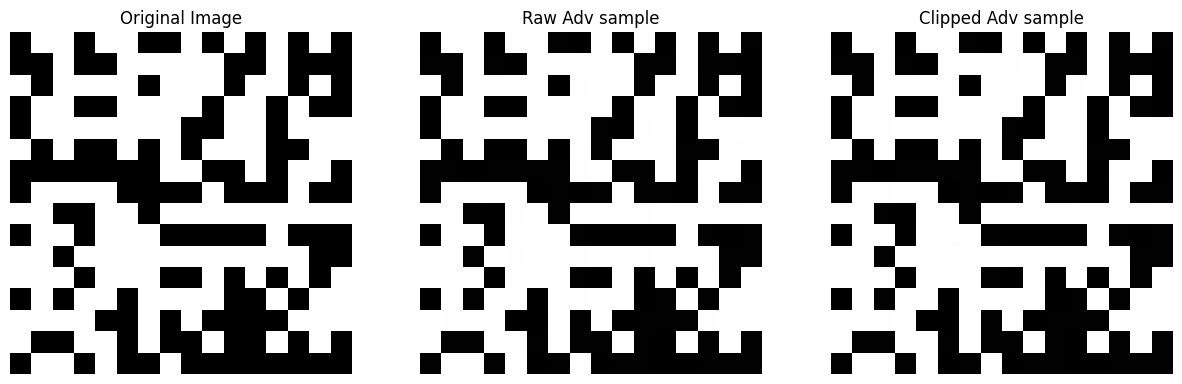

In [12]:
# We can now go ahead and plot the original image and the adversarial example
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1,3,1)

# Detach is called because we calculated gradients
# By detaching we are no removing the need to backpropagate
ax.imshow(X[0].detach().squeeze(dim=0).squeeze(dim=0).cpu(), cmap='gray')
ax.set_axis_off()
ax.set_title(label='Original Image')

# The perturbations are the gradients
ax = fig.add_subplot(1,3,2)
ax.imshow(raw_adversarial_examples[0].detach().squeeze(dim=0).squeeze(dim=0).cpu(), cmap='gray')
ax.set_axis_off()
ax.set_title(label='Raw Adv sample')

ax = fig.add_subplot(1,3,3)
# Detach is called because we calculated gradients
# By detaching we are no removing the need to backpropagate
ax.imshow(clipped_adversarial_examples[0].detach().squeeze().cpu(), cmap='gray')
ax.set_axis_off()
ax.set_title(label='Clipped Adv sample');

### Lab Takeaways:   
- We were able leverage Foolbox to simplify the attack process 
